In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from T2T_ACE.alignment_utilities import load_reference
import T2T_ACE.validator as v
import notebooks.resource_locations as rl
import importlib

/Users/fleharty/opt/anaconda3/envs/newConda/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
# Update the reference genomes to local path
# I have updated the hg38 reference to primary assembly. It will address the issues with alt contigs.
# Load the minimap2 aligner from reference fasta file
# Load HG002 T2T reference
hg002t2t = load_reference(rl.ResourceLocations.hg002t2t)
# Load hg38 reference
hg38 = load_reference(rl.ResourceLocations.hg38)

INFO:root:Loading reference from: /Users/fleharty/resources/hg002v1.0.fasta.gz
INFO:root:Loading reference from: /Users/fleharty/resources/Homo_sapiens_assembly38.fasta


In [4]:
def read_vcf(vcf_path : str) -> pd.DataFrame:
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df

In [45]:
HG2_DRAGEN_cnv = read_vcf(rl.ResourceLocations.HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
HG2_DRAGEN_pass_cnv.head()
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DEL_pass_intervals = []
DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DUP_pass_intervals.append(interval)

print('HG2 DEL intervals:',len(DEL_pass_intervals))
print('HG2 DUP intervals:',len(DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [46]:
importlib.reload(v)

<module 'T2T_ACE.validator' from '/Users/fleharty/mf_cleanup/T2T-ACE/T2T_ACE/validator.py'>

In [47]:
# Testing collect_del_flankings function in validator.py
v.collect_del_flankings("chr1:212910885-212912827", rl.ResourceLocations.hg38, hg38, hg002t2t)

DEL interval: chr1:212910885-212912827 1943
DEL interval Alignments in hg38: 1
DEL interval Alignments in HG2: 1
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:212908885-212910885, 2001, 1, 2
right flanking interval: chr1:212912827-212914827, 2001, 1, 2


ValueError: Intervals should not be overlapping

In [48]:
v.align_interval('chr1:212910691-212910885', rl.ResourceLocations.hg38, hg38, hg002t2t)[1]

[['chr15_MATERNAL:34168333-34168528', 1, 0, 195],
 ['chr15_PATERNAL:29598494-29598689', 1, 0, 195],
 ['chr1_PATERNAL:215949675-215949870', 1, 0, 195],
 ['chr1_MATERNAL:207786664-207786859', 1, 0, 195],
 ['chr8_MATERNAL:80220113-80220308', -1, 0, 195],
 ['chr8_PATERNAL:80341539-80341734', -1, 0, 195]]

In [49]:
# This function is to calculate distance between DEL flankings
def distance_between_flankings(del_interval : str, flanking_size=None):
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    
    # Create flanking intervals for the deletion interval
    # The flanking size is 10% of the SV length
    if flanking_size:
        flanking_size = flanking_size
    else:
        if svlen < 1000:
            flanking_size = 1000
        else:
            flanking_size = int(svlen * 0.1)
    # initiate of flanking intervals        
    left_flanking_hg2_alignment_intervals = []
    right_flanking_hg2_alignment_intervals = []
    left_flanking_interval_aligned = []

    while len(left_flanking_hg2_alignment_intervals) < 2 or len(right_flanking_hg2_alignment_intervals)<2:
        print(f"flanking_size: {flanking_size}")
        left_flanking_pos = pos - flanking_size
        left_flanking_end = pos 
        right_flanking_pos = end
        right_flanking_end = end + flanking_size
        
        left_flanking_interval = v.create_interval(chr, left_flanking_pos, left_flanking_end)
        right_flanking_interval = v.create_interval(chr, right_flanking_pos, right_flanking_end)
        
        # Align the flanking intervals to the reference genome
        left_flanking_interval_aligned = v.align_interval(left_flanking_interval, rl.ResourceLocations.hg38, hg38, hg002t2t)
        right_flanking_interval_aligned = v.align_interval(right_flanking_interval, rl.ResourceLocations.hg38, hg38, hg002t2t)
        
        left_flanking_hg38_alignment_intervals = [interval for interval, strand, q_start, q_end in left_flanking_interval_aligned[0]]
        right_flanking_hg38_alignment_intervals = [interval for interval, strand, q_start, q_end in right_flanking_interval_aligned[0]]
        
        # Grab intervals of flanking region alignments in HG2
        left_flanking_hg2_alignment_intervals = [interval for interval, strand, q_start, q_end in left_flanking_interval_aligned[1]]
        right_flanking_hg2_alignment_intervals = [interval for interval, strand, q_start, q_end in right_flanking_interval_aligned[1]]
        
        # Print out the flanking intervals, their sizes, and the number of alignments in HG002
        print(f"left flanking interval: {left_flanking_interval}, {v.interval_size(left_flanking_interval)}, {len(left_flanking_hg38_alignment_intervals)}, {len(left_flanking_hg2_alignment_intervals)}")
        print(f"right flanking interval: {right_flanking_interval}, {v.interval_size(right_flanking_interval)}, {len(right_flanking_hg38_alignment_intervals)}, {len(right_flanking_hg2_alignment_intervals)}")
        
        # Increase the flanking size by 1000bp if there is less than two alignments in HG002
        # 1000 is arbitrary. But it seems to work well for most of the cases.
        flanking_size = flanking_size + 1000
    
    distance_between_flankings_list = []
    for left_flanking_interval, strand, q_start, q_end in left_flanking_interval_aligned[1]:
        if strand ==1:
            matching_right_flanking_interval = v.find_next_interval(left_flanking_interval, right_flanking_hg2_alignment_intervals)
            if matching_right_flanking_interval:
                distance_between_flankings = v.distance_between_intervals(left_flanking_interval, matching_right_flanking_interval)
                distance_between_flankings_list.append(distance_between_flankings)
                if distance_between_flankings < int(svlen) * 0.5:
                    print('********** Potential DEL **********')
                else:
                    print("----------- No DEL Evidence -----------")
                print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")
            else:
                print(f"No matching right flanking interval for {left_flanking_interval}")
        elif strand == -1:
            matching_right_flanking_interval = v.find_previous_interval(left_flanking_interval, right_flanking_hg2_alignment_intervals)
            distance_between_flankings = v.distance_between_intervals(left_flanking_interval, matching_right_flanking_interval)
            distance_between_flankings_list.append(distance_between_flankings)
            if distance_between_flankings < int(svlen) * 0.5:
                print('********** Potential DEL**********')
            else:
                print("----------- No DEL Evidence -----------")
            print(f"{left_flanking_interval} ({v.interval_size(left_flanking_interval)}bp), {matching_right_flanking_interval} ({v.interval_size(matching_right_flanking_interval)}bp), {distance_between_flankings}")

    return distance_between_flankings_list


In [25]:
def classify_del(del_interval, flanking_size=None): 
    chr, pos, end = v.parse_interval(del_interval)
    svlen = v.interval_size(del_interval)
    print(del_interval, svlen)
    distance_between_flankings_list = distance_between_flankings(del_interval, flanking_size)
    if chr == 'chrY' or chr == 'chrX':
        if len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Homozygous DEL'
        elif len(distance_between_flankings_list)>0 and min(distance_between_flankings_list) <= svlen*0.5:
            return 'Heterozygous DEL'
        else:
            return 'Unknown'
    elif len(distance_between_flankings_list) > 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Complex DEL'
    elif len(distance_between_flankings_list) == 2 and distance_between_flankings_list[0] <= svlen*0.5 and distance_between_flankings_list[1] <= svlen*0.5:
        return 'Homozygous DEL'
    elif len(distance_between_flankings_list) == 2 and min(distance_between_flankings_list) <= svlen*0.5:
        return 'Heterozygous DEL'
    else:
        return 'Unknown'


In [26]:
# Example 1: Homozygous deletion (Needs basepair correction)
classify_del(DEL_pass_intervals[0])

chr1:934321-934937 617
flanking_size: 1000
left flanking interval: chr1:933321-934321, 1001, 1, 2
right flanking interval: chr1:934937-935937, 1001, 1, 2
********** Potential DEL **********
chr1_MATERNAL:366927-367768 (842bp), chr1_MATERNAL:367706-368706 (1001bp), -63
********** Potential DEL **********
chr1_PATERNAL:367566-368407 (842bp), chr1_PATERNAL:368345-369345 (1001bp), -63


'Homozygous DEL'

In [27]:
# Example 2: Heterozygous deletion (No basepair correction is needed)
classify_del(DEL_pass_intervals[1])

chr1:1934923-1935584 662
flanking_size: 1000
left flanking interval: chr1:1933923-1934923, 1001, 1, 2
right flanking interval: chr1:1935584-1936584, 1001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:1371206-1372207 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 659
********** Potential DEL **********
chr1_PATERNAL:1377138-1378207 (1070bp), chr1_PATERNAL:1378207-1379207 (1001bp), -1


'Heterozygous DEL'

In [28]:
# Example 3: Het deletion with complex structure (Needs basepair correction)
classify_del(DEL_pass_intervals[2])

chr1:1934989-1935584 596
flanking_size: 1000
left flanking interval: chr1:1933989-1934989, 1001, 1, 2
right flanking interval: chr1:1935584-1936584, 1001, 1, 2
----------- No DEL Evidence -----------
chr1_MATERNAL:1371272-1372273 (1002bp), chr1_MATERNAL:1372867-1373870 (1004bp), 593
********** Potential DEL **********
chr1_PATERNAL:1377204-1378225 (1022bp), chr1_PATERNAL:1378207-1379207 (1001bp), -19


'Heterozygous DEL'

## DEL classification for all DELs

In [29]:
# Classify all the DELs by DRAGEN with collect_del_flankings function in validator.py

def classify_list_of_DELs(DEL_intervals):
    del_sum_df = pd.DataFrame()
    del_interval_list = []
    del_interval_size_list = []
    flanking_size_list = []
    left_flanking_interval_list = []
    right_flanking_interval_list = []
    left_flanking_hg38_hits_list = []
    right_flanking_hg38_hits_list = []
    left_flanking_hg2_hits_list = []
    right_flanking_hg2_hits_list = []
    distance_between_flankings_list = []
    flanking_connection_strand_list = []
    major_classification_list = []
    minor_classification_list = []
    for interval in DEL_intervals:
        print(interval)
        sum_dict = v.collect_del_flankings(interval, rl.ResourceLocations.hg38, hg38, hg002t2t)
        del_interval_list.append(sum_dict['del_interval'])
        del_interval_size_list.append(sum_dict['del_interval_size'])
        flanking_size_list.append(sum_dict['flanking_size'])
        left_flanking_interval_list.append(sum_dict['left_flanking_interval'])
        right_flanking_interval_list.append(sum_dict['right_flanking_interval'])
        left_flanking_hg38_hits_list.append(sum_dict['left_flanking_hg38_hits'])
        right_flanking_hg38_hits_list.append(sum_dict['right_flanking_hg38_hits'])
        left_flanking_hg2_hits_list.append(sum_dict['left_flanking_hg2_hits'])
        right_flanking_hg2_hits_list.append(sum_dict['right_flanking_hg2_hits'])
        distance_between_flankings_list.append(sum_dict['distance_between_flankings'])
        flanking_connection_strand_list.append(sum_dict['flanking_connection_strand'])
        major_classification_list.append(sum_dict['classification'])
        minor_classification_list.append(sum_dict['minor_classification'])
    del_sum_df['del_interval'] = del_interval_list
    del_sum_df['del_interval_size'] = del_interval_size_list
    del_sum_df['flanking_size'] = flanking_size_list
    del_sum_df['left_flanking_interval'] = left_flanking_interval_list
    del_sum_df['right_flanking_interval'] = right_flanking_interval_list
    del_sum_df['left_flanking_hg38_hits'] = left_flanking_hg38_hits_list
    del_sum_df['right_flanking_hg38_hits'] = right_flanking_hg38_hits_list
    del_sum_df['left_flanking_hg2_hits'] = left_flanking_hg2_hits_list
    del_sum_df['right_flanking_hg2_hits'] = right_flanking_hg2_hits_list
    del_sum_df['distance_between_flankings'] = distance_between_flankings_list
    del_sum_df['flanking_connection_strand'] = flanking_connection_strand_list
    del_sum_df['major_classification'] = major_classification_list
    del_sum_df['minor_classification'] = minor_classification_list
    return del_sum_df
    

In [30]:
importlib.reload(v)
HG2_DRAGEN_DEL_sum_df = classify_list_of_DELs(DEL_pass_intervals)
HG2_DRAGEN_DEL_sum_df.head()

chr1:934321-934937
DEL interval: chr1:934321-934937 617
DEL interval Alignments in hg38: 1
DEL interval Alignments in HG2: 0
flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:932321-934321, 2001, 1, 2
right flanking interval: chr1:934937-936937, 2001, 1, 2


ValueError: Intervals should not be overlapping

In [31]:
HG2_DRAGEN_DEL_sum_df.to_csv('./HG2_DRAGEN_DEL_sum_df.csv', index=False)

NameError: name 'HG2_DRAGEN_DEL_sum_df' is not defined

In [32]:
[(i,v.interval_size(i)) for i in DEL_pass_intervals if 'chr2:888' in i]

[('chr2:88832599-89017488', 184890),
 ('chr2:88832768-89234182', 401415),
 ('chr2:88832769-88859609', 26841)]

In [34]:
# Testing/troubleshooting cell
importlib.reload(v)
v.collect_del_flankings('chr2:88832599-89017488', rl.ResourceLocations.hg38, hg38, hg002t2t)  

DEL interval: chr2:88832599-89017488 184890
DEL interval Alignments in hg38: 1
DEL interval Alignments in HG2: 0
flanking_size: 55467, copy_threshold: 2
left flanking interval: chr2:88777132-88832599, 55468, 1, 2
right flanking interval: chr2:89017488-89072955, 55468, 2, 2
----------- No DEL Evidence -----------
chr2_MATERNAL:88800487-88855942 (55456bp), chr2_MATERNAL:90349757-90405284 (55528bp), 1493814
----------- No DEL Evidence -----------
chr2_PATERNAL:88812943-88868403 (55461bp), chr2_PATERNAL:90274988-90330517 (55530bp), 1406584
----------- Checking DEL Sequence Alignment in HG2 -----------


{'del_interval': 'chr2:88832599-89017488',
 'del_interval_size': 184890,
 'flanking_size': 55467,
 'left_flanking_interval': 'chr2:88777132-88832599',
 'right_flanking_interval': 'chr2:89017488-89072955',
 'left_flanking_hg38_hits': 1,
 'right_flanking_hg38_hits': 2,
 'left_flanking_hg2_hits': 2,
 'right_flanking_hg2_hits': 2,
 'distance_between_flankings': [1493814, 1406584],
 'flanking_connection_strand': ['POS', 'POS'],
 'hg38_plotting_flanking_intervals': ['chr2:88832599-89017488',
  'chr2:88777132-88832599',
  'chr2:89017488-89072955'],
 'hg2_plotting_flanking_intervals': ['chr2_MATERNAL:88800487-88855942',
  'chr2_PATERNAL:88812943-88868403',
  'chr2_MATERNAL:90349757-90405284',
  'chr2_PATERNAL:90274988-90330517'],
 'classification': 'False DEL',
 'minor_classification': 'False DEL'}

In [35]:
import T2T_ACE.duplication_evaluation as duplication_evaluation
duplication_evaluation.eval_dup_interval("chr7:38346551-38364943", rl.ResourceLocations.hg38, rl.ResourceLocations.hg002t2t, hg38, hg002t2t).analyzeDuplicationIntervals()

----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
input dup interval: chr7:38346551-38364943
hg38 dup count: 1
interval: chr7:38346550-38364943	strand: 1, start: 0, end: 18393
hg2 dup count: 1
interval: chr7_MATERNAL:38454519-38472908	strand: 1, start: 0, end: 18393
The DUP interval's classification is Copy Neutral and it will not be corrected
----------------------------------------------------------------
End of Analysis of DUP interval chr7:38346551-38364943(18393bp)
----------------------------------------------------------------


{'dup_interval': 'chr7:38346551-38364943',
 'dup_interval_size': 18393,
 'original_hg38_hit_count': 1,
 'original_hg2_hit_count': 1,
 'original_hg2_mat_hit_count': 1,
 'original_hg2_pat_hit_count': 0,
 'original_dup_interval_major_classification': 'Copy Neutral',
 'original_dup_interval_sub_classification': 'Maternal Copy Neutral',
 'original_dup_interval_contain_big_gap': False,
 'corrected_interval': nan,
 'corrected_interval_size': nan,
 'expanded_length': nan,
 'corrected_hg38_hit_count': nan,
 'corrected_hg2_hit_count': nan,
 'corrected_hg2_mat_hit_count': nan,
 'corrected_hg2_pat_hit_count': nan,
 'corrected_dup_interval_major_classification': nan,
 'corrected_dup_interval_sub_classification': nan,
 'corrected_pos_accuracy': nan,
 'corrected_end_accuracy': nan}

In [36]:
HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Homozygous DEL', 'Heterozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown'])

NameError: name 'HG2_DRAGEN_DEL_sum_df' is not defined

In [37]:
HG2_DRAGEN_DEL_sum_df[HG2_DRAGEN_DEL_sum_df['minor_classification']=='Unknown'].iloc[0]

NameError: name 'HG2_DRAGEN_DEL_sum_df' is not defined

In [38]:
HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown'])

NameError: name 'HG2_DRAGEN_DEL_sum_df' is not defined

In [39]:
# Plot the performance of DRAGEN DEL classification
sns.set(style='white')

# Annotate the unknown classification
maj_classifications = ['TP:Deletion', 'FP:False Deletion', 'Unknown']
maj_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
sub_classifications = ['TP: Heterozygous DEL', 'TP: Homozygous DEL', 'TP: DEL in DUP','TP: Unclassified', 'FP: False DEL', 'Unknown']
sub_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()

f, (ax0, ax1) = plt.subplots(nrows= 1, ncols= 2, figsize=(15,7), sharey=True, gridspec_kw={'width_ratios': [1.2, 2]})
maj_bar = sns.barplot(x=maj_classifications, y=maj_count, ax=ax0, palette='Blues')
ax0.set_xlabel('')
ax0.set_ylabel('Count')
ax0.set_title('Overall Classification', fontsize=12)


sub_bar = sns.barplot(x=sub_classifications, y=sub_count, ax=ax1, palette='Greens')
ax1.set_xlabel('')
ax1.set_title('Genotype Classification', fontsize=12)

plt.xticks(rotation=20, ha='right')

# Annotations for major classifications
for i, count in enumerate(maj_count):
    maj_bar.text(i, count + 1, str(count), ha='center', va='bottom')

# Annotations for sub classifications
for i, count in enumerate(sub_count):
    sub_bar.text(i, count + 1, str(count), ha='center', va='bottom')

plt.suptitle('HG002 DRAGEN v4.2.4 DEL Classification', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.savefig('HG002_DRAGEN_DEL_Classification.png', dpi=300)

NameError: name 'HG2_DRAGEN_DEL_sum_df' is not defined

In [40]:
#TODO: chr6:32657114-32658082 is a real HET DEL. However, T2T-ACE is not able to detect it. Need to figure out why.

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gaoyueya/Documents/GitHub/T2T-ACE/docs//chr1:2122128-2124374_interval_comparison.png'

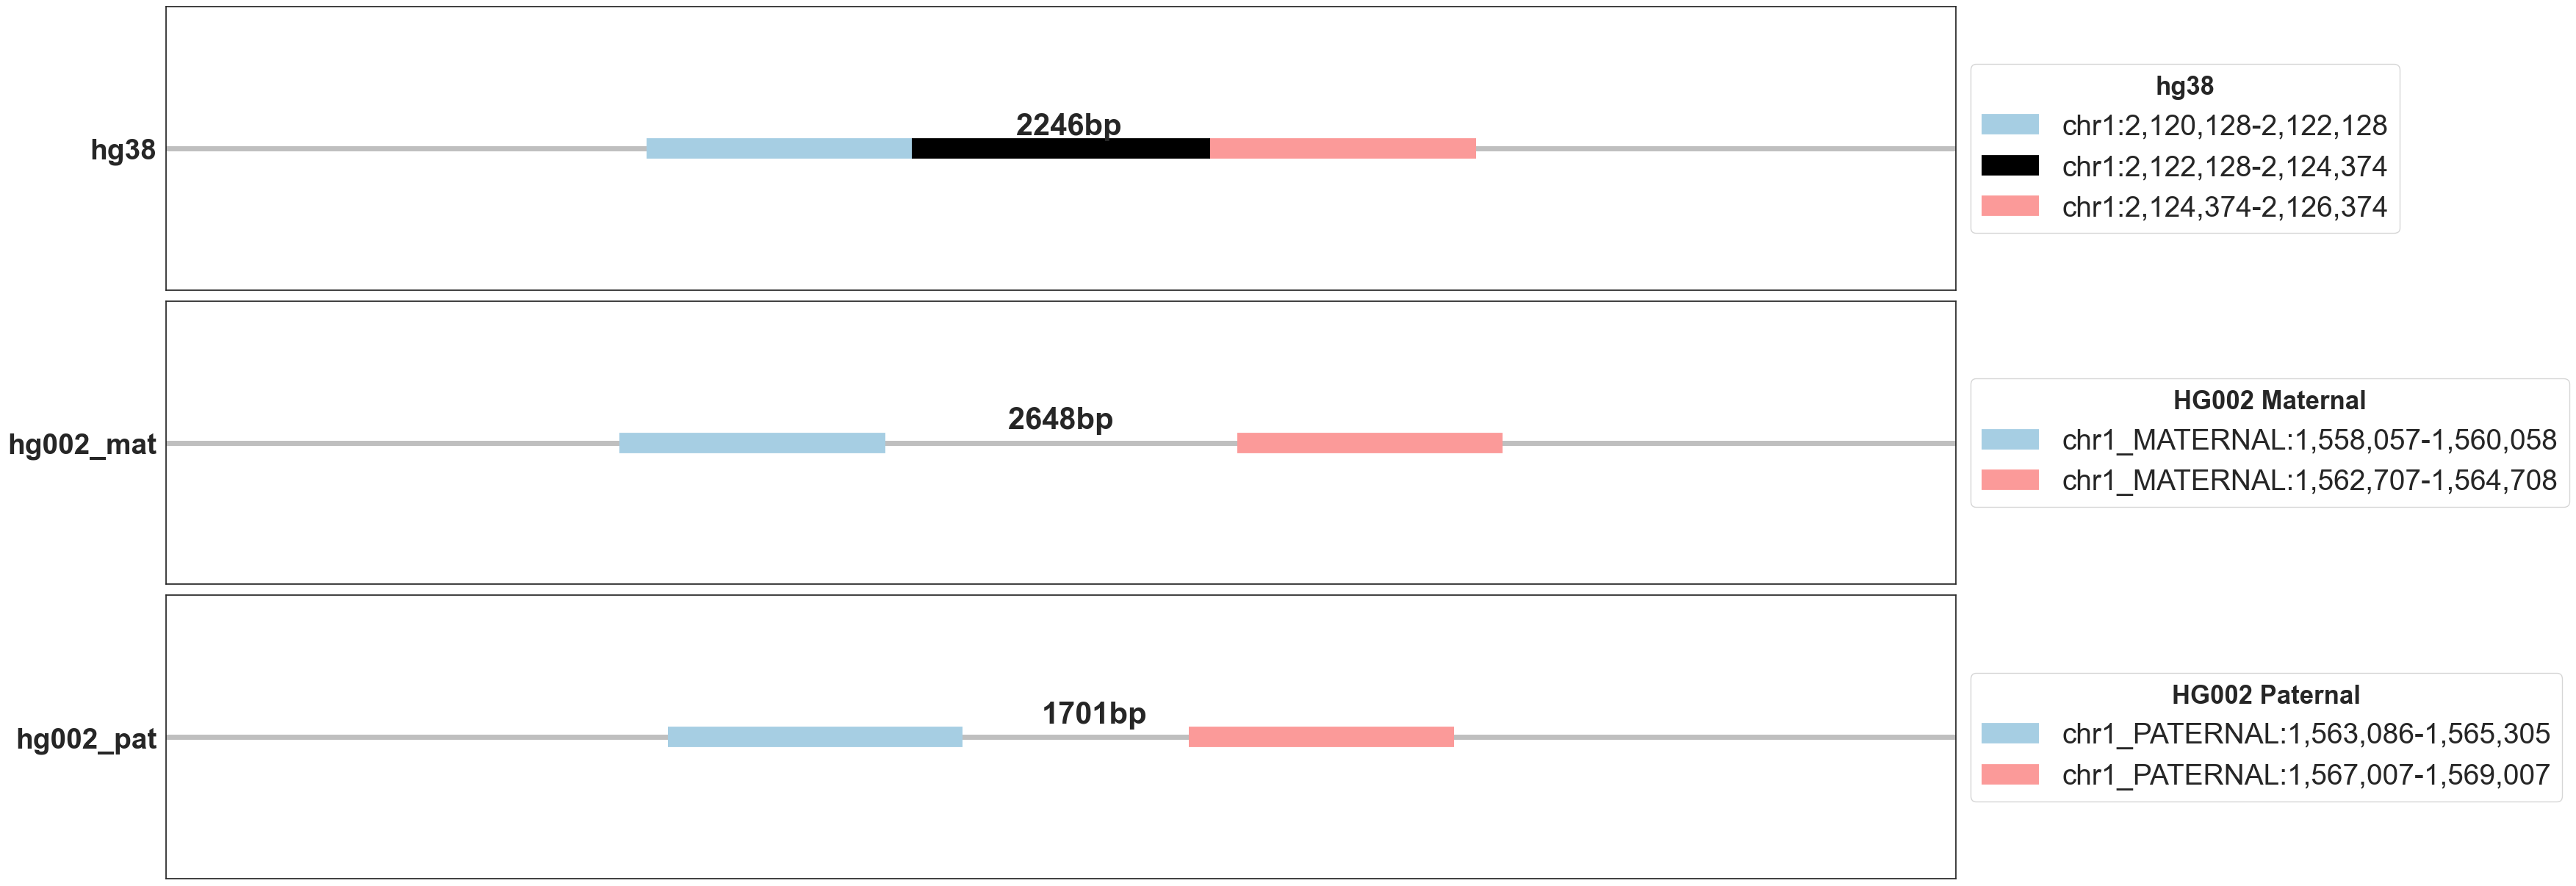

In [41]:
import T2T_ACE.alignment_visualization_utilities as avu
importlib.reload(avu)
avu.PlotIntervals(["chr1:2122128-2124374", "chr1:2120128-2122128", "chr1:2124374-2126374"], ["chr1_MATERNAL:1558057-1560058","chr1_MATERNAL:1562707-1564708","chr1_PATERNAL:1563086-1565305", "chr1_PATERNAL:1567007-1569007"]).plot_intervals_comparison(flanking=True, save=True, savepath='/Users/gaoyueya/Documents/GitHub/T2T-ACE/docs/')

In [42]:
# WEEKLY DEV GOAL
# TODO: 1. Analyze the complex DELs. So far, it seems like the complex DELs are DEL in DUP. I want to check if this is true. 
# TODO: 2. Check if all unknown DELs are FPs. If not FPs, what are they?
# TODO: 3. Develop basepair correction for DELs.
# TODO: 4. The current basepair correction mechanism seems to have flaws. The extended copies are overlapping with each other. Need to fix this.

In [43]:
# prepare GATK-SV DEL output
HG2_GATK_SV_vcf_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1818/GATK-SV-HG002/GATK-SV_HG002_single_sample.vcf"
HG2_GATK_SV_df = read_vcf(HG2_GATK_SV_vcf_path)
HG2_GATK_SV_pass_df = HG2_GATK_SV_df[HG2_GATK_SV_df['FILTER']=='PASS']
HG2_GATK_SV_pass_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gaoyueya/Documents/Projects/TAG-Ticket1818/GATK-SV-HG002/GATK-SV_HG002_single_sample.vcf'

In [44]:
# Make sure there is no 0/0 genotype in the DEL calls
set([row['SAMPLE'].split(':')[0] for index, row in HG2_GATK_SV_pass_df.iterrows() if row['ALT']=='<DEL>'])

NameError: name 'HG2_GATK_SV_pass_df' is not defined

In [ ]:
# Make sure there is no 0/0 genotype in the DUP calls
set([row['SAMPLE'].split(':')[0] for index, row in HG2_GATK_SV_pass_df.iterrows() if row['ALT']=='<DUP>'])

In [ ]:
# Collect all the PASS DEL intervals from GATK-SV
HG2_GATK_SV_pass_DEL_list = []
HG2_GATK_SV_pass_DUP_list = []

for index, row in HG2_GATK_SV_pass_df.iterrows():
    if row['ALT']=='<DEL>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 500:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DEL_list.append(interval)
    elif row['ALT']=='<DUP>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 1000:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DUP_list.append(interval)
        


In [ ]:
print('GATK-SV DEL: ', len(HG2_GATK_SV_pass_DEL_list))
print('GATK-SV DUP: ', len(HG2_GATK_SV_pass_DUP_list))

In [ ]:
importlib.reload(v)
HG2_GATKSV_DEL_sum_df = classify_list_of_DELs(HG2_GATK_SV_pass_DEL_list)
HG2_GATKSV_DEL_sum_df.head()

In [ ]:
HG2_GATKSV_DEL_sum_df['major_classification'].value_counts()

In [ ]:
HG2_GATKSV_DEL_sum_df['minor_classification'].value_counts()

In [ ]:
HG2_GATKSV_DEL_sum_df.to_csv('./HG2_GATKSV_DEL_sum_df.csv', index=False)

In [ ]:
# Plot the performance of GATK-SV vs DRAGEN DEL classification

maj_classifications = ['TP:Deletion', 'FP:False Deletion', 'Unknown']
gakt_sv_maj_count = pd.DataFrame(HG2_GATKSV_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
dragen_maj_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['major_classification'].value_counts().reindex(['DEL', 'False DEL', 'Unknown']))['count'].tolist()
sub_classifications = ['TP: Heterozygous DEL', 'TP: Homozygous DEL', 'TP: DEL in DUP','TP: Unclassified', 'FP: False DEL', 'Unknown']
gatk_sv_sub_count = pd.DataFrame(HG2_GATKSV_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()
dragen_sub_count = pd.DataFrame(HG2_DRAGEN_DEL_sum_df['minor_classification'].value_counts().reindex(['Heterozygous DEL', 'Homozygous DEL', 'DEL in DUP', 'Unclassified DEL', 'False DEL', 'Unknown']))['count'].tolist()


In [ ]:
GATK_SV_maj_count_df = pd.DataFrame({'Count':gakt_sv_maj_count,'Caller':["GATK-SV v4.2.6.1"]*3}, index=maj_classifications)
GATK_dragen_maj_count_df = pd.DataFrame({'Count':dragen_maj_count,'Caller':["DRAGEN v4.2.4"]*3}, index=maj_classifications)
maj_count_df = pd.concat([GATK_SV_maj_count_df, GATK_dragen_maj_count_df], axis=0)
maj_count_df.head()

In [ ]:
# Replace NAN with 0
gatk_sv_sub_count[3] = 0

In [ ]:
GATK_SV_sub_count_df = pd.DataFrame({'Count':gatk_sv_sub_count,'Caller':["GATK-SV v4.2.6.1"]*6}, index=sub_classifications)
GATK_dragen_sub_count_df = pd.DataFrame({'Count':dragen_sub_count,'Caller':["DRAGEN v4.2.4"]*6}, index=sub_classifications)
sub_count_df = pd.concat([GATK_SV_sub_count_df, GATK_dragen_sub_count_df], axis=0)
sub_count_df

In [ ]:
f, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharey=True, gridspec_kw={'width_ratios': [1.2, 2]})

maj_bar = sns.barplot(x=maj_count_df.index, y=maj_count_df['Count'], hue=maj_count_df['Caller'], ax=ax0, palette='Blues')
ax0.set_xlabel('')
ax0.set_ylabel('Count')
ax0.set_title('Overall Classification', fontsize=12)
ax0.legend(loc='upper right')

sub_bar = sns.barplot(x=sub_count_df.index, y=sub_count_df['Count'], hue=sub_count_df['Caller'], ax=ax1, palette='Greens')
ax1.set_xlabel('')
ax1.set_title('Genotype Classification', fontsize=12)
ax1.legend(loc='upper right')

plt.xticks(rotation=20, ha='right')

# Annotations for major classifications
for i, rect in enumerate(maj_bar.patches):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

# Annotations for sub classifications
for i, rect in enumerate(sub_bar.patches):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

plt.suptitle('HG002 GATK-SV v4.2.6.1 vs DRAGEN v4.2.4 DEL Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('HG002_GATKSV_DRAGEN_DEL_Classification.png', dpi=300)

## Evaluate the DUPs

In [ ]:
print(f"HG2 DRAGEN DUP: {len(DUP_pass_intervals)}")
print(f"HG2 GATK-SV DUP: {len(HG2_GATK_SV_pass_DUP_list)}")

In [ ]:
# This function will create a summary df for all the input DUP intervals
def create_dup_sum(interval_list):
    hg2_dup_summary_df = pd.DataFrame()
    hg2_dup_summary_df['interval'] = interval_list
    
    # Collect the results for each interval from dup_eval
    dup_interval_size_list = []
    original_hg38_hit_count_list = []
    original_hg2_hit_count_list = []
    original_hg2_mat_hit_count_list = []
    original_hg2_pat_hit_count_list = []
    original_dup_interval_major_classification_list = []
    original_dup_interval_sub_classification_list = []
    original_dup_interval_contain_big_gap_list = []
    corrected_interval_list = []
    corrected_interval_size_list = []
    expanded_length_list = []
    corrected_hg38_hit_count_list = []
    corrected_hg2_hit_count_list = []
    corrected_hg2_mat_hit_count_list = []
    corrected_hg2_pat_hit_count_list = []
    corrected_dup_interval_major_classification_list = []
    corrected_dup_interval_sub_classification_list = []
    corrected_pos_accuracy_list = []
    corrected_end_accuracy_list = []
    
    for interval in interval_list:
        print(interval)
        interval_sum_dict = duplication_evaluation.eval_dup_interval(interval, ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).analyzeDuplicationIntervals()
        dup_interval_size_list.append(interval_sum_dict['dup_interval_size'])
        original_hg38_hit_count_list.append(interval_sum_dict['original_hg38_hit_count'])
        original_hg2_hit_count_list.append(interval_sum_dict['original_hg2_hit_count'])
        original_hg2_mat_hit_count_list.append(interval_sum_dict['original_hg2_mat_hit_count'])
        original_hg2_pat_hit_count_list.append(interval_sum_dict['original_hg2_pat_hit_count'])
        original_dup_interval_major_classification_list.append(interval_sum_dict['original_dup_interval_major_classification'])
        original_dup_interval_sub_classification_list.append(interval_sum_dict['original_dup_interval_sub_classification'])
        original_dup_interval_contain_big_gap_list.append(interval_sum_dict['original_dup_interval_contain_big_gap'])
        corrected_interval_list.append(interval_sum_dict['corrected_interval'])
        corrected_interval_size_list.append(interval_sum_dict['corrected_interval_size'])
        expanded_length_list.append(interval_sum_dict['expanded_length'])
        corrected_hg38_hit_count_list.append(interval_sum_dict['corrected_hg38_hit_count'])
        corrected_hg2_hit_count_list.append(interval_sum_dict['corrected_hg2_hit_count'])
        corrected_hg2_mat_hit_count_list.append(interval_sum_dict['corrected_hg2_mat_hit_count'])
        corrected_hg2_pat_hit_count_list.append(interval_sum_dict['corrected_hg2_pat_hit_count'])
        corrected_dup_interval_major_classification_list.append(interval_sum_dict['corrected_dup_interval_major_classification'])
        corrected_dup_interval_sub_classification_list.append(interval_sum_dict['corrected_dup_interval_sub_classification'])
        corrected_pos_accuracy_list.append(interval_sum_dict['corrected_pos_accuracy'])
        corrected_end_accuracy_list.append(interval_sum_dict['corrected_end_accuracy'])
    
    hg2_dup_summary_df['dup_interval_size'] = dup_interval_size_list
    hg2_dup_summary_df['original_hg38_hit_count'] = original_hg38_hit_count_list
    hg2_dup_summary_df['original_hg2_hit_count'] = original_hg2_hit_count_list
    hg2_dup_summary_df['original_hg2_mat_hit_count'] = original_hg2_mat_hit_count_list
    hg2_dup_summary_df['original_hg2_pat_hit_count'] = original_hg2_pat_hit_count_list
    hg2_dup_summary_df['original_dup_interval_major_classification'] = original_dup_interval_major_classification_list
    hg2_dup_summary_df['original_dup_interval_sub_classification'] = original_dup_interval_sub_classification_list
    hg2_dup_summary_df['original_dup_interval_contain_big_gap'] = original_dup_interval_contain_big_gap_list
    hg2_dup_summary_df['corrected_interval'] = corrected_interval_list
    hg2_dup_summary_df['corrected_interval_size'] = corrected_interval_size_list
    hg2_dup_summary_df['expanded_length'] = expanded_length_list
    hg2_dup_summary_df['corrected_hg38_hit_count'] = corrected_hg38_hit_count_list
    hg2_dup_summary_df['corrected_hg2_hit_count'] = corrected_hg2_hit_count_list
    hg2_dup_summary_df['corrected_hg2_mat_hit_count'] = corrected_hg2_mat_hit_count_list
    hg2_dup_summary_df['corrected_hg2_pat_hit_count'] = corrected_hg2_pat_hit_count_list
    hg2_dup_summary_df['corrected_dup_interval_major_classification'] = corrected_dup_interval_major_classification_list
    hg2_dup_summary_df['corrected_dup_interval_sub_classification'] = corrected_dup_interval_sub_classification_list
    hg2_dup_summary_df['corrected_pos_accuracy'] = corrected_pos_accuracy_list
    hg2_dup_summary_df['corrected_end_accuracy'] = corrected_end_accuracy_list
    return hg2_dup_summary_df

In [ ]:
import T2T_ACE.interval_list_evaluation as IntervalListEvaluation

In [ ]:
IntervalListEvaluation.eval_interval_list(DUP_pass_intervals[:3], ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).create_dup_sum()

In [ ]:
HG2_DRAGEN_DUP_sum_df = create_dup_sum(DUP_pass_intervals)